In [1]:
import os
import numpy as np
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy import units as u
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Spatially resolved SF relations for EDGE, at 7" resolution (not deprojected)
### We use the 'smo' mask for detections but the 'str' mask for considering non-detections.  These differ in velocity width so we scale the 'str' mask noise down to the median velocity width for the 'smo' mask.

In [2]:
# limit the columns we read to avoid information overload
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_sigsfr_sm','EW_Halpha_sm','ZOH_sm','BPT_sm']

globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMass'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coSmoothDv_smo7'])
try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('edge.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('NGC4047.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coSmoothDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coSmoothDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)

Median unmasked velocity width is 860.0
Median masked velocity width is 420.0
Noise estimates will be scaled down by 0.6988362419217079


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['emom0_12'] *= nsefactor
conomasktab['emom0_12'].name = 'emom0max_12'
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_sigsfr_sm', 'EW_Halpha_sm', 'ZOH_sm', 'BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'mom0_12', 'emom0_12', 'mom1_12', 'emom1_12', 'mom2_12', 'emom2_12', 'sigmol', 'e_sigmol', 'sigmol_fo', 'e_sigmol_fo', 'mom0_13', 'emom0_13', 'mom1_13', 'emom1_13', 'mom2_13', 'emom2_13', 'emom0max_12', 'caMass']


In [5]:
# Apply a 3-sigma cut to both axes
det = (fluxtab['mom0_12']>3*fluxtab['emom0_12']) & (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm'])
codata = fluxtab['mom0_12'][det]
hadata = fluxtab['flux_Halpha_sm'][det]
sig_mol_det = fluxtab['sigmol'][det]
sig_sfr_det = fluxtab['flux_sigsfr_sm'][det]
sig_star_det = fluxtab['sigstar_sm'][det]
stmass_det = fluxtab['caMass'][det]

# Ratios
t_dep_det = Column(sig_mol_det.quantity/sig_sfr_det.quantity, name='t_dep')
sig_ssfr_det = Column(sig_sfr_det.quantity/sig_star_det.quantity, name='sig_ssfr')

Table([sig_mol_det,sig_sfr_det,t_dep_det,sig_star_det,sig_ssfr_det]).pprint(max_width=100)

    sigmol       flux_sigsfr_sm     t_dep     sigstar_sm    sig_ssfr 
solMass / pc2 solMass / (Gyr pc2)    Gyr    solMass / pc2   1 / Gyr  
------------- ------------------- --------- ------------- -----------
    18.158768           2.3043823  7.880102      44.81753 0.051416986
    47.770554            8.223912  5.808738      41.46368  0.19834015
     43.96933                 nan       nan     52.632156         nan
    21.177143                 nan       nan     37.097176         nan
    20.126877           1.7495028 11.504341      44.81753 0.039036125
    33.876198           4.4350634  7.638267      41.46368  0.10696261
     35.55225                 nan       nan     52.632156         nan
     14.54331           1.8236948 7.9746404     10.442046  0.17464918
    22.737122           13.988529 1.6254119     58.508404  0.23908581
     44.97658           18.350536 2.4509683     58.731354   0.3124487
          ...                 ...       ...           ...         ...
    61.821274       

In [6]:
# Derived quantities for the CO non-detections
ndet = (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm']) & ~det
# Upper limits need to be calculated explicitly since e_sigmol is only the uncertainty for detections
sig_mol_ndet = msd_co(3*fluxtab['emom0max_12'][ndet], name='sig_mol_ul')
sig_sfr_ndet = fluxtab['flux_sigsfr_sm'][ndet]
sig_star_ndet = fluxtab['sigstar_sm'][ndet]

# Ratios
t_dep_ndet = Column(sig_mol_ndet.quantity/sig_sfr_ndet.quantity, name='t_dep_ul')
sig_ssfr_ndet = Column(sig_sfr_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ndet')

Table([sig_mol_ndet,sig_sfr_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

  sig_mol_ul     flux_sigsfr_sm    t_dep_ul    sigstar_sm  sig_ssfr_ndet
solMass / pc2 solMass / (Gyr pc2)    Gyr     solMass / pc2    1 / Gyr   
------------- ------------------- ---------- ------------- -------------
    29.864283                 nan        nan      20.80953           nan
    29.076519           15.188943  1.9143214     62.707306    0.24221967
    28.891478           3.3711135   8.570307     62.707306     0.0537595
    28.839254           1.3258075   21.75222     62.707306    0.02114279
    30.622854                 nan        nan     37.097176           nan
    29.398457           2756.5076 0.01066511      73.41992      37.54441
    29.884035           0.9375904   31.87323      44.81753    0.02092017
    29.827902           0.7596884   39.26334      44.81753   0.016950697
    31.713083                 nan        nan     37.097176           nan
    36.809826                 nan        nan       14.1044           nan
          ...                 ...        ...       

## Spatially resolved CO vs. Halpha

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


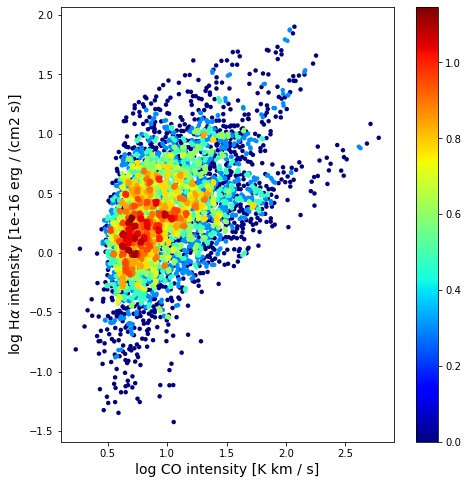

In [7]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(codata, hadata, log=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='jet')
plt.xlabel('log CO intensity ['+str(codata.unit)+']',fontsize=14)
plt.ylabel(r'log H$\alpha$ intensity ['+str(hadata.unit)+']',fontsize=14)
plt.colorbar(sc)

## Spatially resolved star formation law (extinction corrected)

==CO Detections==
Number of valid, invalid values: 5375 12
==Non-detections==
Number of valid, invalid values: 25933 642


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


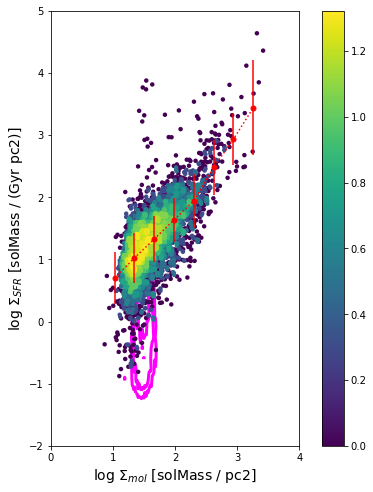

In [8]:
# Select data to plot (must be loggable)
valid = (~np.isnan(sig_mol_det)) & (~np.isnan(sig_sfr_det)) & (sig_mol_det>0) & (sig_sfr_det>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(valid)[0]),len(np.nonzero(~valid)[0]))
valid_ndet = (~np.isnan(sig_mol_ndet)) & (~np.isnan(sig_sfr_ndet)) & (sig_mol_ndet>0) & (sig_sfr_ndet>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(valid_ndet)[0]),len(np.nonzero(~valid_ndet)[0]))

# Get the plotting arrays
x_det, y_det, z_det, *hist = xy2hist(sig_mol_det[valid], 
                                     sig_sfr_det[valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_mol_ndet[valid_ndet], 
                                         sig_sfr_ndet[valid_ndet], log=True, bins=[50,50])

# Make the scatter plot (physical values)
fig, ax = plt.subplots(figsize=(8,8))
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='viridis')
x_bin, y_bin, y_err = xy2binned(sig_mol_det[valid], sig_sfr_det[valid], bins=8)
ax.errorbar(x_bin, y_bin, yerr=y_err, color='r', marker='o', ms=5, ls=':', label='all')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{mol}$ ['+str(sig_mol_det.unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{SFR}$ ['+str(sig_sfr_det.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0,4)
ax.set_ylim(-2,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.colorbar(sc)

## Separated by stellar mass [cf. Fig. 17(a) of Bolatto+17]

Points from high-mass galaxies: 3036
Points from low-mass galaxies: 2302


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


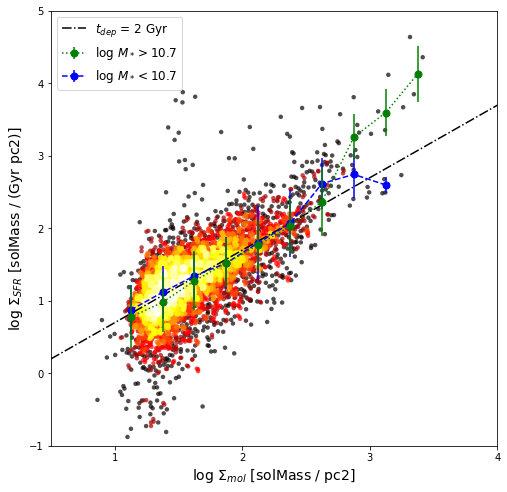

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
xlims = [0.5, 4]
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='hot', alpha=0.7)

himass = valid & (stmass_det>10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (stmass_det<=10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sig_mol_det[himass], 
                                      sig_sfr_det[himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sig_mol_det[lomass], 
                                      sig_sfr_det[lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

# 2 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(2)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')

plt.xlabel(r'log $\Sigma_{mol}$ ['+str(sig_mol_det.unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{SFR}$ ['+str(sig_sfr_det.unit)+']',fontsize=14)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Depletion time vs. local stellar density

==CO Detections==
Number of valid, invalid values: 5375 12
Points from high-mass galaxies: 3036
Points from low-mass galaxies: 2302
==Non-detections==
Number of valid, invalid values: 24945 1630


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


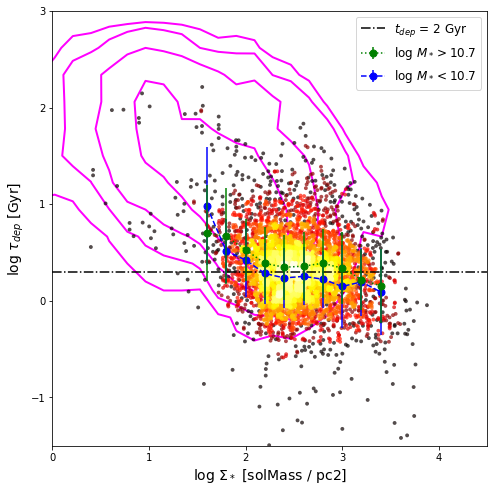

In [10]:
# Select data to plot (must be loggable)
sstd_valid = (~np.isnan(sig_star_det)) & (~np.isnan(t_dep_det)) & (sig_star_det>0) & (t_dep_det>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(sstd_valid)[0]),len(np.nonzero(~sstd_valid)[0]))
himass = sstd_valid & (stmass_det>10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = sstd_valid & (stmass_det<=10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

sstd_valid_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(sstd_valid_ndet)[0]),len(np.nonzero(~sstd_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_star_det[sstd_valid], t_dep_det[sstd_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[sstd_valid_ndet], 
                                         t_dep_ndet[sstd_valid_ndet], log=True, bins=[30,30])

xhi_bin, yhi_bin, yhi_err = xy2binned(sig_star_det[himass], 
                                      t_dep_det[himass], bins=10, range=[1.5,3.5])
xlo_bin, ylo_bin, ylo_err = xy2binned(sig_star_det[lomass], 
                                      t_dep_det[lomass], bins=10, range=[1.5,3.5])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('hot')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=2,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star_det.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep_det.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(np.log10(2), ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Depletion time vs. local sSFR

==CO Detections==
Number of valid, invalid values: 5375 12
Points from high-mass galaxies: 3036
Points from low-mass galaxies: 2302
==Non-detections==
Number of valid, invalid values: 24945 1630


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


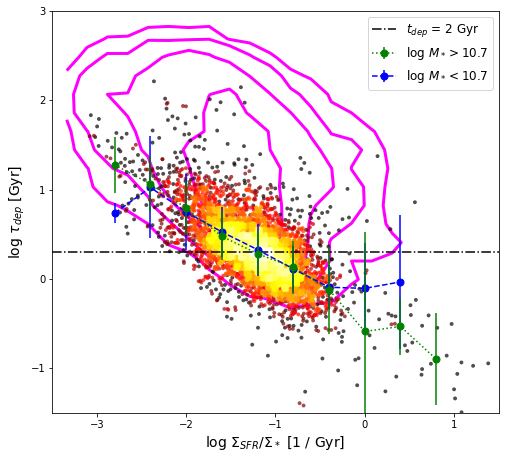

In [11]:
# Select data to plot (must be loggable)
ssft_valid = (~np.isnan(sig_ssfr_det)) & (~np.isnan(t_dep_det)) & (sig_ssfr_det>0) & (t_dep_det>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(ssft_valid)[0]),len(np.nonzero(~ssft_valid)[0]))
himass = ssft_valid & (stmass_det>10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = ssft_valid & (stmass_det<=10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

ssft_valid_ndet = (~np.isnan(sig_ssfr_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(ssft_valid_ndet)[0]),len(np.nonzero(~ssft_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr_det[ssft_valid], t_dep_det[ssft_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[ssft_valid_ndet], 
                                         t_dep_ndet[ssft_valid_ndet], log=True, bins=[40,40])

xhi_bin, yhi_bin, yhi_err = xy2binned(sig_ssfr_det[himass], 
                                      t_dep_det[himass], bins=10, range=[-3,1])
xlo_bin, ylo_bin, ylo_err = xy2binned(sig_ssfr_det[lomass], 
                                      t_dep_det[lomass], bins=10, range=[-3,1])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('hot')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr_det.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep_det.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(np.log10(2), ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')